# Tour of hera_sim

This notebook briefly introduces some of the effects that can be modeled with `hera_sim`.

In [1]:
%matplotlib notebook
import aipy
import uvtools
import numpy as np
import pylab as plt

In [2]:
from hera_sim import foregrounds, noise, sigchain, rfi

/home/bobby/HERA/dev/fix_tutorial/hera_sim/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/home/bobby/HERA/dev/fix_tutorial/hera_sim/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/home/bobby/HERA/dev/fix_tutorial/hera_sim/hera_sim/__init__.py:36: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next major release will involve modifications to the package's API, which move toward a regularization of the way in which hera_sim methods are interfaced with; in particular, changes will be made such that the Simulator class is the most intuitive way of inter

In [3]:
fqs = np.linspace(.1,.2,1024,endpoint=False)
lsts = np.linspace(0,2*np.pi,10000, endpoint=False)
times = lsts / (2*np.pi) * aipy.const.sidereal_day
bl_len_ns = np.array([30., 0, 0])

## Foregrounds

### Diffuse Foregrounds

In [4]:
Tsky_mdl = noise.HERA_Tsky_mdl['xx']
vis_fg_diffuse = foregrounds.diffuse_foreground(lsts, fqs, bl_len_ns, Tsky_mdl)

<IPython.core.display.Javascript object>


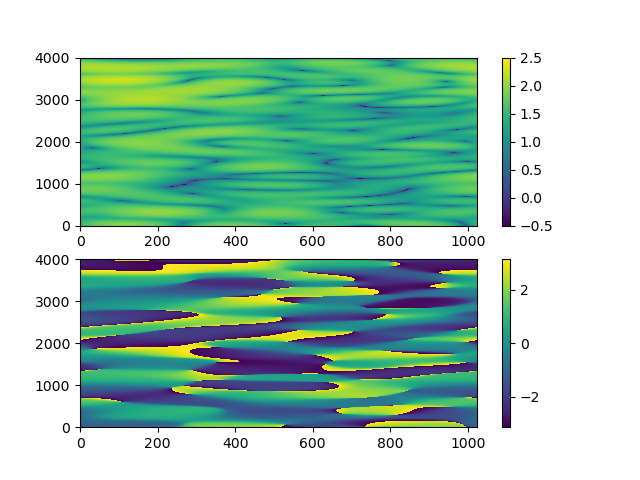

In [5]:
MX, DRNG = 2.5, 3
plt.figure()
plt.subplot(211); uvtools.plot.waterfall(vis_fg_diffuse, mode='log', mx=MX, drng=DRNG); plt.colorbar(); plt.ylim(0,4000)
plt.subplot(212); uvtools.plot.waterfall(vis_fg_diffuse, mode='phs'); plt.colorbar(); plt.ylim(0,4000)
plt.show()

### Point-Source Foregrounds

In [6]:
vis_fg_pntsrc = foregrounds.pntsrc_foreground(lsts, fqs, bl_len_ns, nsrcs=200)

<IPython.core.display.Javascript object>


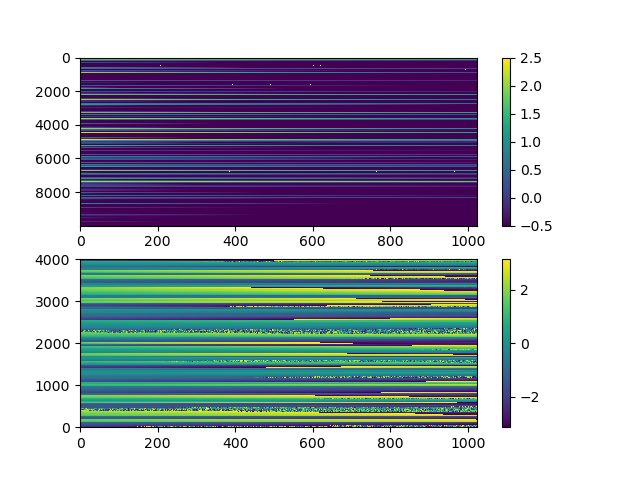

/home/bobby/anaconda3/envs/fix_tutorial/lib/python3.7/site-packages/uvtools/plot.py:40: RuntimeWarning: divide by zero encountered in log10
  data = np.log10(data)


In [7]:
plt.figure()
plt.subplot(211); uvtools.plot.waterfall(vis_fg_pntsrc, mode='log', mx=MX, drng=DRNG); plt.colorbar()#; plt.ylim(0,4000)
plt.subplot(212); uvtools.plot.waterfall(vis_fg_pntsrc, mode='phs'); plt.colorbar(); plt.ylim(0,4000)
plt.show()

### Diffuse and Point-Source Foregrounds

In [8]:
vis_fg = vis_fg_diffuse + vis_fg_pntsrc

<IPython.core.display.Javascript object>


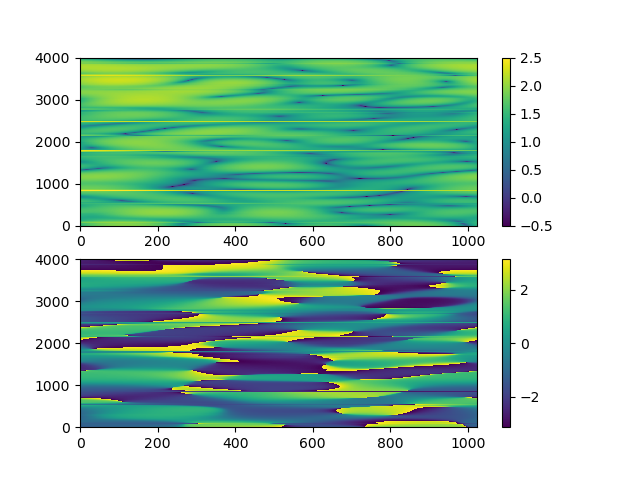

In [9]:
plt.figure()
plt.subplot(211); uvtools.plot.waterfall(vis_fg, mode='log', mx=MX, drng=DRNG); plt.colorbar(); plt.ylim(0,4000)
plt.subplot(212); uvtools.plot.waterfall(vis_fg, mode='phs'); plt.colorbar(); plt.ylim(0,4000)
plt.show()

## Noise

In [10]:
tsky = noise.resample_Tsky(fqs,lsts,Tsky_mdl=noise.HERA_Tsky_mdl['xx'])
t_rx = 150.
omega_p = noise.bm_poly_to_omega_p(fqs)
nos_jy = noise.sky_noise_jy(tsky + t_rx, fqs, lsts, omega_p)

<IPython.core.display.Javascript object>


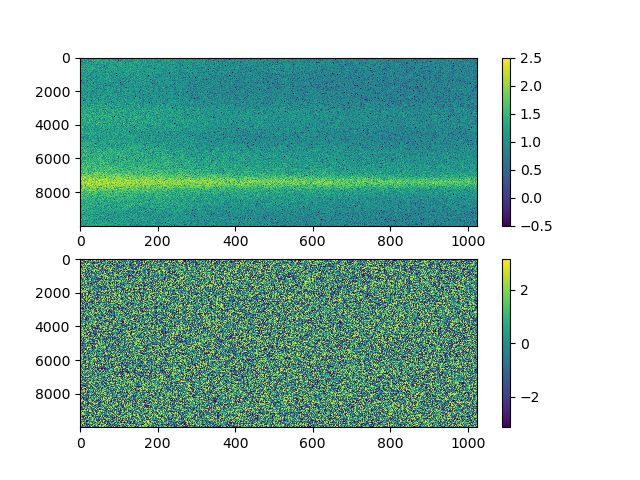

In [11]:
plt.figure()
plt.subplot(211); uvtools.plot.waterfall(nos_jy, mode='log', mx=MX, drng=DRNG); plt.colorbar()#; plt.ylim(0,4000)
plt.subplot(212); uvtools.plot.waterfall(nos_jy, mode='phs'); plt.colorbar()#; plt.ylim(0,4000)
plt.show()

In [12]:
vis_fg_nos = vis_fg + nos_jy

<IPython.core.display.Javascript object>


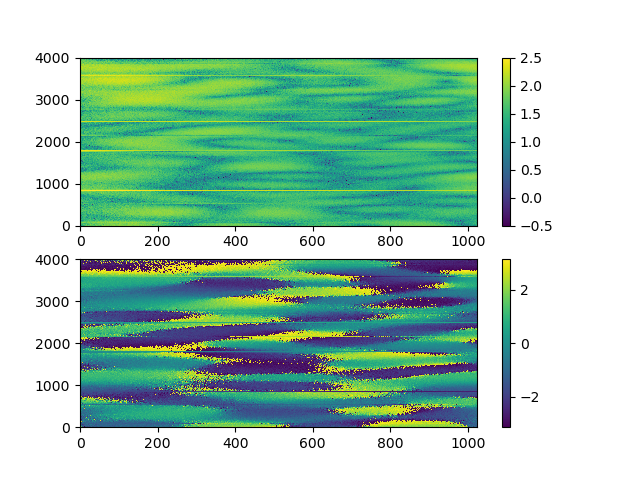

In [13]:
plt.figure()
plt.subplot(211); uvtools.plot.waterfall(vis_fg_nos, mode='log', mx=MX, drng=DRNG); plt.colorbar(); plt.ylim(0,4000)
plt.subplot(212); uvtools.plot.waterfall(vis_fg_nos, mode='phs'); plt.colorbar(); plt.ylim(0,4000)
plt.show()

## RFI

In [14]:
rfi1 = rfi.rfi_stations(fqs, lsts)
rfi2 = rfi.rfi_impulse(fqs, lsts, chance=.02)
rfi3 = rfi.rfi_scatter(fqs, lsts, chance=.001)
rfi_all = rfi1 + rfi2 + rfi3

<IPython.core.display.Javascript object>


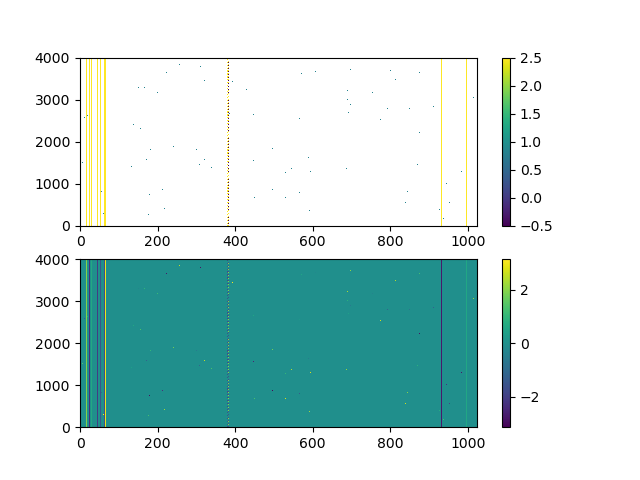

In [15]:
plt.figure()
plt.subplot(211); uvtools.plot.waterfall(rfi_all, mode='log', mx=MX, drng=DRNG); plt.colorbar(); plt.ylim(0,4000)
plt.subplot(212); uvtools.plot.waterfall(rfi_all, mode='phs'); plt.colorbar(); plt.ylim(0,4000)
plt.show()

In [16]:
vis_fg_nos_rfi = vis_fg_nos + rfi_all

<IPython.core.display.Javascript object>


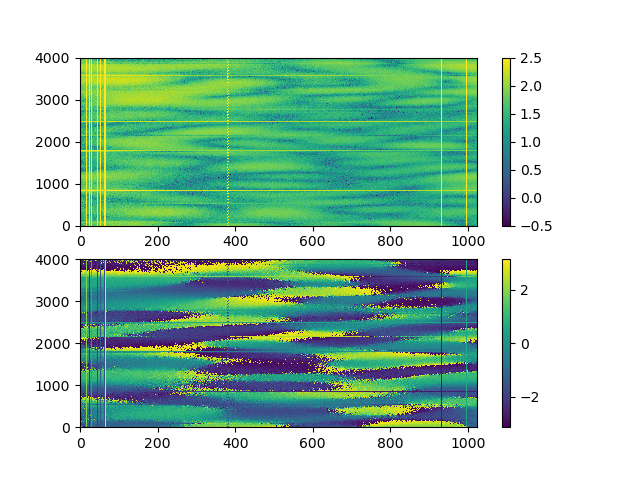

In [17]:
plt.figure()
plt.subplot(211); uvtools.plot.waterfall(vis_fg_nos_rfi, mode='log', mx=MX, drng=DRNG); plt.colorbar(); plt.ylim(0,4000)
plt.subplot(212); uvtools.plot.waterfall(vis_fg_nos_rfi, mode='phs'); plt.colorbar(); plt.ylim(0,4000)
plt.show()

## Gains

<IPython.core.display.Javascript object>


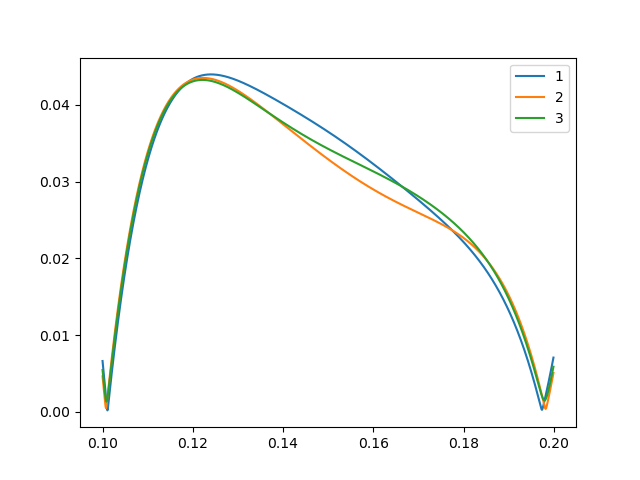

In [18]:
g = sigchain.gen_gains(fqs, [1,2,3])
plt.figure()
for i in g: plt.plot(fqs, np.abs(g[i]), label=str(i))
plt.legend(); plt.show()
gainscale = np.average([np.median(np.abs(g[i])) for i in g])
MXG = MX + np.log10(gainscale)

<IPython.core.display.Javascript object>


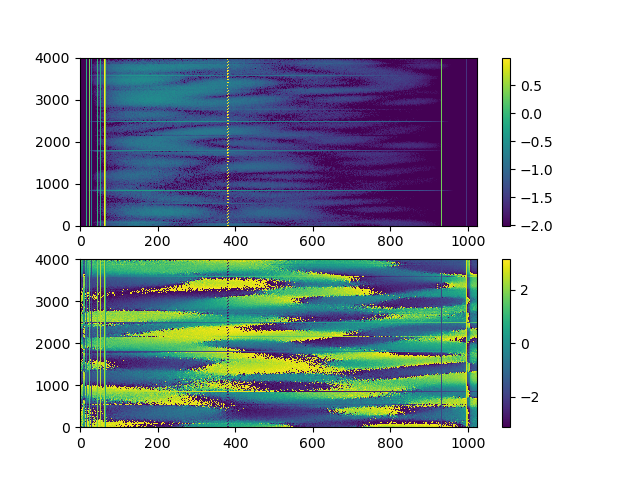

In [19]:
vis_total = sigchain.apply_gains(vis_fg_nos_rfi, g, (1,2))
plt.figure()
plt.subplot(211); uvtools.plot.waterfall(vis_total, mode='log', mx=MXG, drng=DRNG); plt.colorbar(); plt.ylim(0,4000)
plt.subplot(212); uvtools.plot.waterfall(vis_total, mode='phs'); plt.colorbar(); plt.ylim(0,4000)
plt.show()

## Crosstalk

<IPython.core.display.Javascript object>


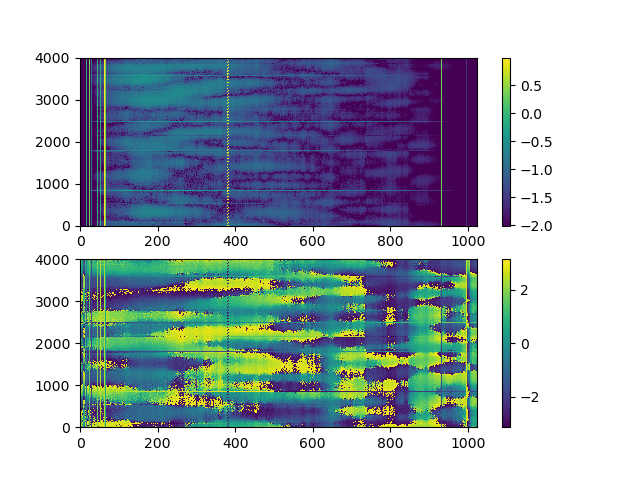

In [20]:
xtalk = sigchain.gen_whitenoise_xtalk(fqs)
vis_xtalk = sigchain.apply_xtalk(vis_fg_nos_rfi, xtalk)
vis_xtalk = sigchain.apply_gains(vis_xtalk, g, (1,2))
plt.figure()
plt.subplot(211); uvtools.plot.waterfall(vis_xtalk, mode='log', mx=MXG, drng=DRNG); plt.colorbar(); plt.ylim(0,4000)
plt.subplot(212); uvtools.plot.waterfall(vis_xtalk, mode='phs'); plt.colorbar(); plt.ylim(0,4000)
plt.show()